In [2]:
# We explicitly pin numpy<2 to prevent installing NumPy 2.0, 
# which causes the "binary incompatibility" error with PyArrow.
%additional_python_modules awswrangler, matplotlib, plotly, scipy, numpy<2

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Additional python modules to be included:
awswrangler
matplotlib
plotly
scipy
numpy<2


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import plotly.express as px
import re

spark = SparkSession.builder.getOrCreate()

trending_path = "s3://yt-analytics-cs6705-data/curated/trending/"

trending_df = spark.read.parquet(trending_path)

trending_df.printSchema()

Trying to create a Glue session for the kernel.
Session Type: glueetl
Session ID: 88c2e1e7-2fcc-4a56-b0bd-6860f0078f9b
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
--additional-python-modules awswrangler,matplotlib,plotly,scipy,numpy<2
Waiting for session 88c2e1e7-2fcc-4a56-b0bd-6860f0078f9b to get into ready status...
Session 88c2e1e7-2fcc-4a56-b0bd-6860f0078f9b has been created.
root
 |-- channel_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- default_lang: string (nullable = true)
 |-- duration_iso: string (nullable = true)
 |-- dimension: string (nullable = true)
 |-- definition: string (nullable = true)
 |-- caption: string (nullable = true)
 |-- source_file: string (nullable = true)
 |-- trending_date_raw: string (nullable = true)
 |-- 

In [2]:
TOP_N = 200  # change as you like

top_videos_df = (
    trending_df
    .filter(F.col("view_count").isNotNull())
    .orderBy(F.col("view_count").desc())
    .select(
        "video_id",
        "title",
        "channel_id",
        "region",
        "trending_date",
        "view_count",
        "like_count",
        "comment_count"
    ).limit(TOP_N)
)

top_videos_df.show(truncate=False)

pdf_top = top_videos_df.toPandas()
pdf_top.head()


+-----------+-----------------------------------------------------------------------------------------------+------------------------+------+-------------+----------+----------+-------------+
|video_id   |title                                                                                          |channel_id              |region|trending_date|view_count|like_count|comment_count|
+-----------+-----------------------------------------------------------------------------------------------+------------------------+------+-------------+----------+----------+-------------+
|BKOVzHcjEIo|Dhurandhar Official Trailer | Ranveer Singh | Aditya Dhar | In Cinemas 5th December 2025       |UCcXQd6kHKm0b41x8zMVMmMg|CA    |2025-11-21   |33732176  |430228    |28987        |
|tunE9m6Capc|Tu Meri Main Tera Main Tera Tu Meri - OFFICIAL TEASER | Kartik, Ananya | Sameer V | 25 Dec 2025|UCKQKIY2YlI4L5QVg7hhfjrQ|CA    |2025-11-25   |32587227  |278628    |4592         |
|tunE9m6Capc|Tu Meri Main Tera Main Tera

In [3]:


# Helper to strip emojis / non-ASCII so matplotlib's font doesn't choke
def strip_non_ascii(text):
    if text is None:
        return ""
    return re.sub(r'[^\x00-\x7F]+', '', text)

def plot_data(pdf_top, plot_title):
    pdf_top_plot = pdf_top.copy()

    # Build a shortened, cleaned title for x-axis labels
    pdf_top_plot["short_title"] = (
        pdf_top_plot["title"]
            .apply(strip_non_ascii)
            .str.slice(0, 40) + "..."
    )

    # Set default font size for all elements
    plt.rc('font', size=22) 

    plt.figure(figsize=(20, 15))
    plt.bar(pdf_top_plot["short_title"], pdf_top_plot["view_count"])
    plt.xticks(rotation=75, ha="right")
    plt.ylabel("View Count")
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.title(plot_title)
    plt.tight_layout()

    # Add gridlines
    plt.grid(True) # Set to True to show gridlines

    # Customize gridline appearance (optional)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add minor gridlines (optional)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.2, alpha=0.5)
    return plt


In [4]:
def get_top_videos_by_region(region: str | None = None, top_n: int = 20):
    df = trending_df
    
    # Filter by region if passed
    if region is not None:
        df = df.filter(F.col("region") == region)

    # Filter by current date (Spark date)
    today = F.current_date()

    top_df = (
        df.filter(F.col("trending_date") == today)
          .filter(F.col("view_count").isNotNull())
          .orderBy(F.col("view_count").desc())
          .select(
              "video_id",
              "title",
              "channel_id",
              "region",
              "trending_date",
              "view_count",
              "like_count",
              "comment_count"
          )
          .limit(top_n)
    )

    return top_df.toPandas()

def plotTrending(pdf, titleString):
    # Truncate strings to a maximum length of 20 characters
    pdf['short_title'] = pdf['title'].str.slice(0, 20)

    fig = px.bar(
        pdf,
        x="short_title",
        y="view_count",
        title=titleString,
        labels={
            "title": "",
            "view_count": "Total Views"
        }
    )
    doNotPrint = fig.update_layout(xaxis=dict(tickangle=45))
    return fig

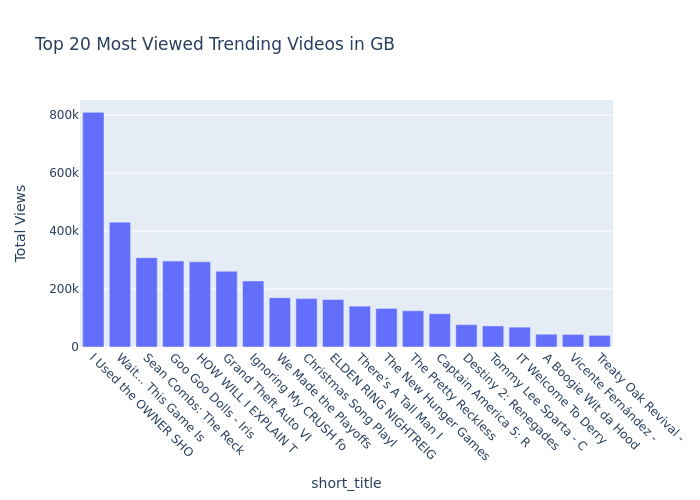

In [5]:
pdf_us = get_top_videos_by_region("US", 20)
pdf_us.head()
titleString = f"Top {len(pdf_us)} Most Viewed Trending Videos in GB"
fig = plotTrending(pdf_us, titleString)
%plotly fig

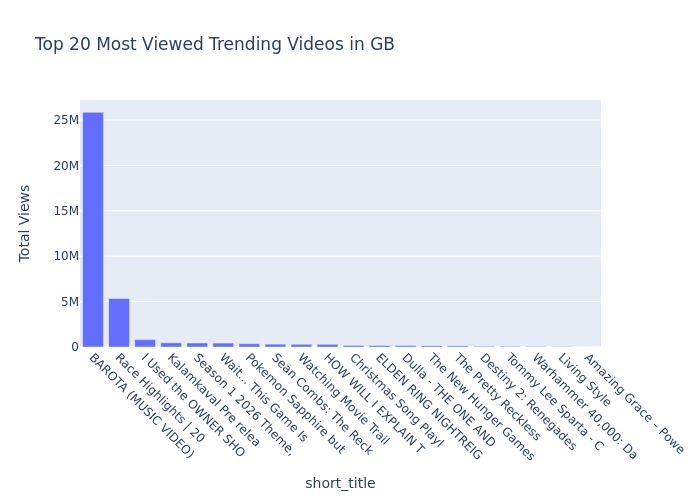

In [6]:
pdf_ca = get_top_videos_by_region("CA", 20)
pdf_ca.head()
titleString = f"Top {len(pdf_ca)} Most Viewed Trending Videos in GB"
fig = plotTrending(pdf_ca, titleString)
%plotly fig

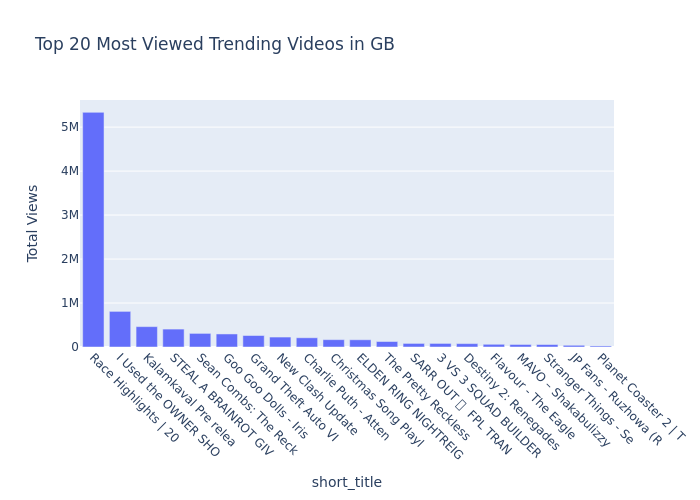

In [7]:
pdf_gb = get_top_videos_by_region("GB", 20)
pdf_gb.head()
titleString = f"Top {len(pdf_gb)} Most Viewed Trending Videos in GB"
fig = plotTrending(pdf_gb, titleString)
%plotly fig

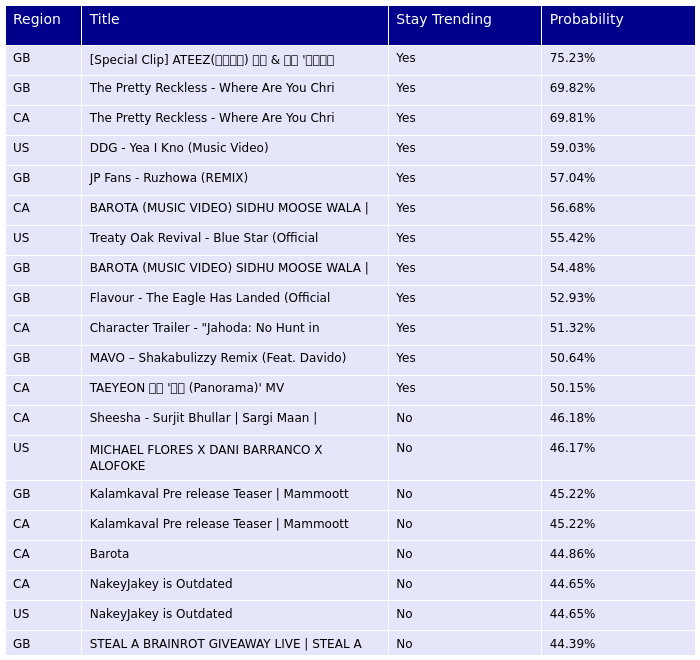

In [39]:
import awswrangler as wr
import pandas as pd
import plotly.graph_objects as go

# Define your Athena query
athena_query = """
WITH latest AS (
    SELECT max(ingest_date) AS max_ingest_date
    FROM youtube_analytics.curated_predictions
)
SELECT 
    p.region,
    p.video_id,
    p.title,
    p.view_count,
    p.prob_stay_trending_next,
    p.pred_stay_trending_next
FROM youtube_analytics.curated_predictions p
JOIN latest l
  ON p.ingest_date = l.max_ingest_date
ORDER BY prob_stay_trending_next DESC
LIMIT 20;
"""

# Specify your Glue database name
glue_database = "youtube_analytics"

# Define a path to a bucket you know exists
my_s3_path = "s3://yt-analytics-cs6705-data/athena-results/"

# Execute the Athena query and get results as a Pandas DataFrame
try:
    df_results = wr.athena.read_sql_query(
        sql=athena_query, 
        database=glue_database,
        s3_output=my_s3_path,  # <--- Add this line
        ctas_approach=False    # Keep this False for simple SELECT queries
    )
except Exception as e:
    print(f"Error executing Athena query: {e}")
    
# Convert 'prob_stay_trending_next' column to percentage string with 2 decimal places
df_results['ProbPercentage'] = (df_results['prob_stay_trending_next'] * 100).round(2).astype(str) + '%'
# Convert 'pred_stay_trending_next' column to 'yes' or 'no'
df_results['StayTrending'] = df_results['pred_stay_trending_next'].map({1.0: 'Yes', 0.0: 'No'})
# Shorten the title to 40 characters
df_results['short_title'] = df_results['title'].str.slice(0, 40)
header_values = ['region','short_title','StayTrending','ProbPercentage']
display_header_values = ['Region','Title','Stay Trending','Probability']

# ... (Previous data preparation code remains the same) ...

# 1. Update the Figure with explicit font sizes and row heights
fig = go.Figure(data=[go.Table(
    columnwidth=[1, 4, 2, 2],  # Relative column widths
    header=dict(
        values=display_header_values,
        font=dict(size=14, color='white'), # Increase font size here
        fill_color='darkblue',             # (Optional) Better contrast
        align='left',
        height=40                          # Taller header row
    ),
    cells=dict(
        values=[df_results[col] for col in header_values],
        font=dict(size=12, color='black'), # Increase font size here
        fill_color='lavender',             # (Optional) Alternating colors aid readability
        align='left',
        height=30                          # Taller data rows
    )
)])

# Calculate height based on number of rows
height_per_row = 30 
header_height = 40 
# Add a small buffer (e.g., 20px) to prevent scrollbars
total_height = header_height + (len(df_results) * height_per_row) + 20

# 2. Update layout to remove huge margins
doNotDisplay = fig.update_layout(
    height=total_height,
    # Do NOT set a huge width. Let autosize handle the width to fit the notebook cell.
    # If you must set it, keep it reasonable (e.g., 800-1000).
    autosize=True, 
    margin=dict(l=5, r=5, t=5, b=5), # Removes whitespace borders
)

%plotly fig